In [1]:
import numpy as np
from PIL import Image
import os
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [96]:
tf.__version__

'1.7.0'

In [2]:
def img_to_np(filename):
    img = Image.open(filename) 
    data = np.array(img, dtype = 'float32')
    data = data.reshape((1, *data.shape))
    return data

def convert_to_npy(filename):
    img = Image.open(filename) 
    data = np.array(img, dtype = 'uint8')
    return data

In [3]:
gray_dir = 'data/good_patches_gray/'
color_dir = 'data/good_patches/'
counter = 0
for file in os.listdir(gray_dir):
    if file.endswith('.png'):
        if counter == 0:
            gray_data = img_to_np(gray_dir + file)
            color_data = img_to_np(color_dir + file[5:])
        else:
            new_gray_data = img_to_np(gray_dir + file)
            new_color_data = img_to_np(color_dir + file[5:])
            gray_data = np.append(gray_data, new_gray_data, axis=0)
            color_data = np.append(color_data, new_color_data, axis=0)
        counter +=1
        if counter % 10 == 0:
            print(counter)
        if counter == 100:
            break
gray_data = gray_data.reshape((*gray_data.shape, 1))

10
20
30
40
50
60
70
80
90
100


In [25]:
color_img = img_to_np('data/good_patches_gray/gray_10000_123436_52628.png')

In [26]:
color_img.shape

(1, 500, 500)

In [57]:
# DATASET OBJECT
class Dataset(object):
    def __init__(self, gray_dir, color_dir, batch_size, img_dim, color_channels=4, shuffle=False, data_type='float32'):
        """
        Construct a Dataset object to iterate over grayscale images and their corresponding color images, if any
        
        Inputs:
        - gray_dir: String for the directory storing the gray images, with the ending slash
        - color_dir: String for the directory storing the color images, with the ending slahs. 
        None if there is no groundtruth color images (at testing time)
        - batch_size: Integer giving number of images per minibatch
        - img_dim: Integer for the width and height of the images
        - color_channels: Integer for the number of channels in the color images
        - shuffle: Boolean for shuffling the data on each epoch
        - data_type: String for specifying the numpy data type to convert to for the images
        """
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.batch_size = batch_size
        self.img_dim = img_dim
        self.color_channels = color_channels
        self.shuffle = shuffle
        self.data_type = data_type
        self.gray_img_names = os.listdir(gray_dir)
        if color_dir is None:
            self.color_img_names = None
        else:
            self.color_img_names = os.listdir(color_dir)

    # Convert a single image to numpy array with shape 1 x H x W x C
    def img_to_np(self, filename, img_type):
        assert img_type == 'gray' or img_type == 'color', "img_type has to be 'gray' or 'color'"
        img = Image.open(filename)
        data = np.array(img, dtype=self.data_type)
        if img_type == 'gray':
            data = data.reshape((1, *data.shape, 1))
        elif img_type == 'color':
            data = data.reshape((1, *data.shape))
        return data

    # Given a list of gray image files, create a numpy array with shape B x H x W x C for the gray images and
    # the color images, where N is the batch size
    def imgs_to_batch(self, gray_filelist, color_filelist=None):
        B = len(gray_filelist)
        gray_batch = np.zeros((B, self.img_dim, self.img_dim, 1))
        for i in range(B):
            gray_batch[i,:,:,:] = self.img_to_np(gray_filelist[i], 'gray')
        if color_filelist is not None:
            color_batch = np.zeros((B, self.img_dim, self.img_dim, self.color_channels))
            for i in range(B):
                color_batch[i,:,:,:] = self.img_to_np(color_filelist[i], 'color')
        else:
            color_batch = None
        return gray_batch, color_batch
        
    def __iter__(self):
        N = len(self.gray_img_names)
        B = self.batch_size
        if self.shuffle:
            random.shuffle(self.gray_img_names)
        color_img_names = [img_name[5:] for img_name in self.gray_img_names] # remove the prefix 'gray_'
        # testing
        self.color_img_names = color_img_names
        gray_files = [self.gray_dir + img_name for img_name in self.gray_img_names]
        if self.color_dir is not None:
            color_files = [self.color_dir + img_name for img_name in color_img_names]
            return iter(self.imgs_to_batch(gray_files[i:i+B], color_files[i:i+B]) for i in range(0, N, B))
        else:
            return iter(self.imgs_to_batch(gray_files[i:i+B], None) for i in range(0, N, B))

In [84]:
train = Dataset('data/good_patches_gray/', 'data/good_patches/', 10, 500)

In [85]:
for t, (gray, color) in enumerate(train):
    idx = t
    if t == 0:
        gray_data_0 = gray
        color_data_0 = color
    if t == 1:
        gray_data_1 = gray
        color_data_1 = color
    if t > 1:
        break

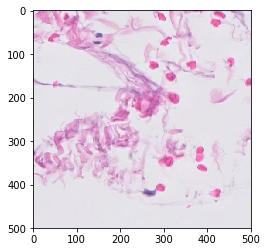

In [94]:
plt.imshow(color_data_0[5,:,:,:].astype(np.uint8))

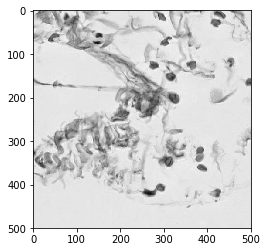

In [95]:
plt.imshow(gray_data_0[5,:,:,:].reshape(gray_data_0.shape[1:3]), cmap='gray')

In [102]:
# VAE CODE DEVELOPMENT with the TensorFlow functional API
def encoder(gray_imgs, latent_dim, conv_filters=[32,16,8], kernel_sizes=[3,3,3], conv_strides=[2,2,1], 
            act=tf.nn.relu, initializer=tf.contrib.layers.xavier_initializer(), data_type=tf.float32):
    """
    Encode the input grayscale images into latent representations
    
    Inputs:
    - gray_imgs: Tensor for a batch of gray images with shape B x W x H x C
    - latent_dim: Integer for the latent dimension
    - conv_filers: List of integers for the numbers of filers
    - kernel_sizes: List of integers for the convolution kernel sizes
    - conv_strides: List of integers for the stride sizes
    - act: the activation function (non-linearity) for all the layers
    - initializer: the weight initializer for all the layers
    - data_type: Tensor data type for random Gaussian sampling
    
    Outputs:
    - z: Tensor for the latent representations with shape B x latent_dim
    - latent_mean: Tensor for the encoder latent means with shape B x latent_dim. Useful for KL divergence.
    - latent_sd: Tensor for the encoder latent standard devations withe shape B x latent_dim. Useful for KL divergence.
    """
    B = tf.shape(gray_imgs)[0] # batch size
    x = tf.layers.conv2d(inputs=gray_imgs, filters=conv_filters[0], kernel_size=kernel_sizes[0], 
                         strides=conv_strides[0], padding='same', activation=act, kernel_initializer=initializer)
    x = tf.layers.max_pooling2d(x, 2, 2)
    x = tf.layers.conv2d(inputs=x, filters=conv_filters[1], kernel_size=kernel_sizes[1], 
                         strides=conv_strides[1], padding='same', activation=act, kernel_initializer=initializer)
    x = tf.layers.max_pooling2d(x, 2, 2)
    x = tf.layers.conv2d(inputs=x, filters=conv_filters[2], kernel_size=kernel_sizes[2], 
                         strides=conv_strides[2], padding='same', activation=act, kernel_initializer=initializer)
    x = tf.layers.max_pooling2d(x, 2, 2)
    x = tf.contrib.layers.flatten(x)
    latent_mean = tf.layers.dense(inputs=x, units=latent_dim, activation=act, kernel_initializer=initializer)
    latent_sd = tf.layers.dense(inputs=x, units=latent_dim, activation=act, kernel_initializer=initializer)

    # Apply the reparameterization trick to generate latent samples
    epsilon = tf.random_normal(shape=[B, latent_dim], dtype=data_type)
    latent_samples = latent_mean + tf.multiply(epsilon, latent_sd)
    return latent_samples, latent_mean, latent_sd

def test_encoder():
    """Unit test to for the encoder method. Check for output dimensions"""
    tf.reset_default_graph()
    B, H, W, C = 64, 256, 256, 1
    latent_dim = 16
    with tf.device('/cpu:0'):
        gray_imgs = tf.zeros((B, H, W, C))
        latent_samples, latent_mean, latent_sd = encoder(gray_imgs, latent_dim)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        latent_samples_np, latent_mean_np, latent_sd_np = sess.run([latent_samples, latent_mean, latent_sd])
        print('Output shape should be (%d, %d)' % (B, latent_dim))
        print('latent_samples shape: ' + str(latent_samples_np.shape))
        print('latent_mean shape: ' + str(latent_mean_np.shape))
        print('latent_sd shape: ' + str(latent_sd_np.shape))
test_encoder()

Output shape should be (64, 16)
latent_samples shape: (64, 16)
latent_mean shape: (64, 16)
latent_sd shape: (64, 16)


In [ ]:
def decoder(latent_samples, input_dim, output_dim=256, input_channels=1, output_channels=4, deconv_filters=[8,16,32], 
            kernel_sizes=[3,3,3], deconv_strides=[1,2,2], act=tf.nn.relu, 
            initializer=tf.contrib.layers.xavier_initializer()):
    """
    Decode the latent samples into output color images
    
    Inputs:
    - latent_samples: Tensor for the samples drawn from the latent distribution with shape B x latent_dim
    - input_dim: Integer for the width and height of the first transformation of latent_samples
    - output_dim: Integer for the width and height of the final output
    - input_channels: Integer for the number of channels of the first transformation of latent_samples
    - output_channels: Integer for the number of channels of the final output
    - deconv_filters: List of integers for the deconvolution numbers of filters
    - kernel_sizes: List of integers for the deconvolution kernel sizes
    - deconv_strides: List of integers for the deconvolution strides
    - act: the activation function (non-linearity) for all the layers
    - initializer: the weight initializer for all the layers
    
    Outputs:
    - color_imgs: Tensor for a batch of output color images with shape B x output_dim x output_dim x output_channels
    """
    x = tf.layers.dense(inputs=latent_samples, units=input_dim*input_dim, activation=act, 
                        kernel_initializer=initializer)
    x = tf.reshape(x, [-1, input_dim, input_dim, input_channels])
    x = tf.layers.conv2d_transpose(inputs=x, filters=deconv_filters[0], kernel_size=kernel_sizes[0], 
                                   strides=deconv_strides[0], padding='valid', activation=act, 
                                   kernel_initializer=initializer)
    x = tf.layers.conv2d_transpose(inputs=x, filters=deconv_filters[1], kernel_size=kernel_sizes[1], 
                                   strides=deconv_strides[1], padding='valid', activation=act, 
                                   kernel_initializer=initializer)
    x = tf.layers.conv2d_transpose(inputs=x, filters=deconv_filters[2], kernel_size=kernel_sizes[2], 
                                   strides=deconv_strides[2], padding='valid', activation=act, 
                                   kernel_initializer=initializer)
    x = tf.contrib.layers.flatten(x)
    x = tf.layers.dense(inputs=x, units=output_dim*output_dim*output_channels, activation=act, 
                        kernel_initializer=initializer)
    color_imgs = tf.reshape(x, [-1, output_dim, output_dim, output_channels])
    return color_imgs

def test_decoder():
    """Unit test to for the decoder method. Check for output dimensions"""
    tf.reset_default_graph()
    B = 64
    latent_dim = 16
    input_dim, output_dim, input_channels, output_channels = 32, 128, 1, 4
    with tf.device('/cpu:0'):
        latent_samples = tf.zeros((B, latent_dim))
        color_imgs = decoder(latent_samples, input_dim, output_dim, input_channels, output_channels)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        color_imgs_np = sess.run(color_imgs)
        print('Output shape should be (%d, %d, %d, %d)' % (B, output_dim, output_dim, output_channels))
        print('color_imgs shape: ' + str(color_imgs_np.shape))
test_decoder()

Instructions for updating:
Use the retry module or similar alternatives.


In [97]:
tf.contrib.layers.xavier_initializer

Instructions for updating:
Use the retry module or similar alternatives.


<function tensorflow.contrib.layers.python.layers.initializers.xavier_initializer>

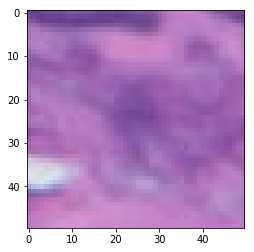

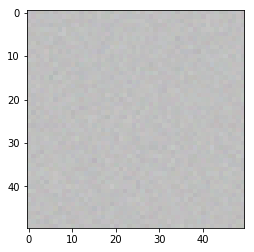

0 398071040.0 398070900.0 119.40734


In [ ]:
tf.reset_default_graph()

batch_size = 6

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 50, 50, 1], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 50, 50, 4], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 50 * 50 * 4])

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2
inputs_decoder = math.floor(inputs_decoder)

def encoder(X_in, activation=tf.nn.relu):
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 50, 50, 1])
        x = tf.layers.conv2d(X, filters=16, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=16, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=16, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd

def decoder(sampled_z, activation=tf.nn.relu):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=activation)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=activation)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=4, strides=1, padding='same', activation=activation)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=50*50*4, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 50, 50, 4])
        return img

sampled, mn, sd = encoder(X_in)
dec = decoder(sampled)

unreshaped = tf.reshape(dec, [-1, 50*50*4])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


for i in range(1000):
    sess.run(optimizer, feed_dict = {X_in: gray_data[0:2,0:50,0:50,:], Y: color_data[0:2,0:50,0:50,:]})
    
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], 
                                               feed_dict = {X_in: gray_data[0:2,0:50,0:50,:], Y: color_data[0:2,0:50,0:50,:]})
        plt.imshow(color_data[0,0:50,0:50,:].astype(np.uint8))
        plt.show()
        example = d[0] * 255
        plt.imshow(example.astype(np.uint8))
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

In [57]:
batch[0].shape

(28, 28)

In [9]:
color_data[0,0:50,0:50,:].shape

(50, 50, 4)

In [37]:
color_data[0,0:50,0:50,:].shape

(50, 50, 4)

In [16]:
color_dir = 'data/good_patches/'
img = Image.open(color_dir + os.listdir(color_dir)[1]) 

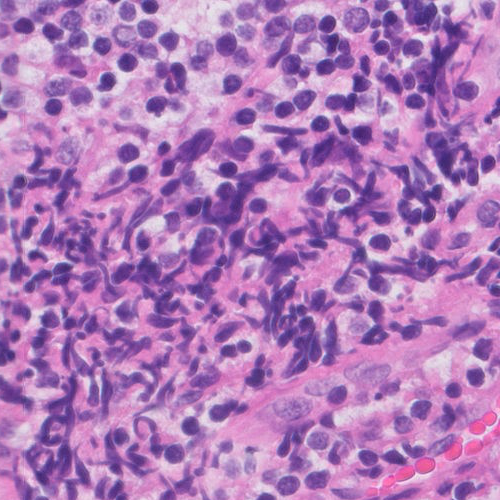

In [34]:
img

In [72]:
foo = img_to_np(color_dir + os.listdir(color_dir)[1])

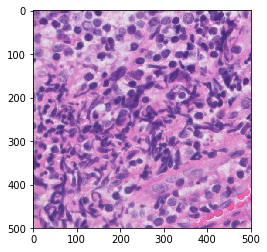

In [79]:
plt.imshow(color_data[0,:,:,:])
plt.show()

In [117]:
d * 255

array([[[[254.99976, 254.99976, 254.9996 , 254.9996 ],
         [254.99948, 254.9996 , 254.99963, 254.99963],
         [254.99973, 254.99963, 254.99951, 254.99963],
         ...,
         [254.99966, 254.99957, 254.99982, 254.99973],
         [254.99957, 254.99966, 254.99985, 254.99976],
         [254.99963, 254.9997 , 254.99976, 254.99966]],

        [[254.99979, 254.99948, 254.99954, 254.9996 ],
         [254.99976, 254.99954, 254.99954, 254.9996 ],
         [254.99976, 254.9997 , 254.99963, 254.99957],
         ...,
         [254.99973, 254.99973, 254.99973, 254.9996 ],
         [254.9996 , 254.99973, 254.9997 , 254.99976],
         [254.99957, 254.99973, 254.99948, 254.99966]],

        [[254.99966, 254.99963, 254.9997 , 254.99948],
         [254.99976, 254.9997 , 254.99973, 254.9997 ],
         [254.99939, 254.9997 , 254.99966, 254.99979],
         ...,
         [254.99963, 254.99973, 254.9997 , 254.99963],
         [254.99951, 254.9996 , 254.99976, 254.99973],
         [254.9996 

In [64]:
foo = foo.astype('int')

In [67]:
foo.shape

(1, 500, 500, 4)

In [53]:
foo.shape

(500, 500, 4)

In [73]:
foo.shape

(1, 500, 500, 4)

In [57]:
foo.shape

(500, 500, 4)

In [69]:
foo[0,0:100,0:100,:].shape

(100, 100, 4)

In [87]:
foo.dtype

dtype('float32')

In [84]:
bar = np.array(foo, dtype = 'uint8')

In [78]:
bar.shape

(1, 500, 500, 4)

In [82]:
color_data[2,0:50,0:50,:].shape

(50, 50, 4)

In [83]:
bar = np.array(color_data[2,0:50,0:50,:], dtype='unit8')

TypeError: data type "unit8" not understood

In [86]:
type(color_data[2,0:50,0:50,:])

numpy.ndarray

In [91]:
foo = np.array(color_data[2,0:50,0:50,:], dtype='float32')

In [93]:
np.array(foo, dtype='unit8')

TypeError: data type "unit8" not understood

In [95]:
foo.shape

(50, 50, 4)

In [97]:
color_data[2,0:50,0:50,:].shape

(50, 50, 4)

In [98]:
mark = Image.fromarray(color_data[2,0:50,0:50,:])

TypeError: Cannot handle this data type

In [107]:
color_data[0,:,:,:].shape

(500, 500, 4)

In [110]:
chris = Image.fromarray(color_data[0,:,:,:])

TypeError: Cannot handle this data type

In [109]:
color_data[0,:,:,:].shape

(500, 500, 4)

In [113]:
color_data[0,:,:,:].astype(np.uint8)

array([[[107,  70, 147, 255],
        [105,  68, 145, 255],
        [103,  69, 146, 255],
        ...,
        [134,  90, 169, 255],
        [133,  90, 169, 255],
        [137,  94, 173, 255]],

       [[116,  75, 151, 255],
        [108,  70, 145, 255],
        [103,  65, 140, 255],
        ...,
        [133,  86, 166, 255],
        [130,  83, 164, 255],
        [132,  85, 166, 255]],

       [[131,  88, 160, 255],
        [127,  84, 156, 255],
        [118,  75, 147, 255],
        ...,
        [133,  79, 163, 255],
        [129,  75, 159, 255],
        [129,  77, 162, 255]],

       ...,

       [[141,  91, 164, 255],
        [145,  89, 162, 255],
        [147,  87, 157, 255],
        ...,
        [231, 229, 234, 255],
        [230, 228, 233, 255],
        [229, 228, 233, 255]],

       [[138,  82, 155, 255],
        [135,  75, 145, 255],
        [128,  67, 134, 255],
        ...,
        [230, 228, 233, 255],
        [230, 228, 233, 255],
        [229, 228, 233, 255]],

       [[145

In [119]:
d[0].astype(np.uint8) * 255

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)